In [19]:
# Step 1: Import libraries
import pandas as pd
import numpy as np

# Step 2: Load the dataset
df = pd.read_csv("data/diabetic_data.csv")

# Step 3: Preview the dataset
df.head()

# Step 4: Basic info
print("Shape:", df.shape)
df.info()

# Step 5: Replace missing values represented by '?'
df.replace("?", np.nan, inplace=True)

# Step 6: Check nulls
df.isnull().sum().sort_values(ascending=False)


Shape: (101766, 50)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 50 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   encounter_id              101766 non-null  int64 
 1   patient_nbr               101766 non-null  int64 
 2   race                      101766 non-null  object
 3   gender                    101766 non-null  object
 4   age                       101766 non-null  object
 5   weight                    101766 non-null  object
 6   admission_type_id         101766 non-null  int64 
 7   discharge_disposition_id  101766 non-null  int64 
 8   admission_source_id       101766 non-null  int64 
 9   time_in_hospital          101766 non-null  int64 
 10  payer_code                101766 non-null  object
 11  medical_specialty         101766 non-null  object
 12  num_lab_procedures        101766 non-null  int64 
 13  num_procedures            101766 non-nu

weight                      98569
max_glu_serum               96420
A1Cresult                   84748
medical_specialty           49949
payer_code                  40256
race                         2273
diag_3                       1423
diag_2                        358
diag_1                         21
encounter_id                    0
troglitazone                    0
tolbutamide                     0
pioglitazone                    0
rosiglitazone                   0
acarbose                        0
miglitol                        0
citoglipton                     0
tolazamide                      0
examide                         0
glipizide                       0
insulin                         0
glyburide-metformin             0
glipizide-metformin             0
glimepiride-pioglitazone        0
metformin-rosiglitazone         0
metformin-pioglitazone          0
change                          0
diabetesMed                     0
glyburide                       0
repaglinide   

In [20]:
# Check readmission categories
df['readmitted'].value_counts()


readmitted
NO     54864
>30    35545
<30    11357
Name: count, dtype: int64

In [21]:
# Create binary target: 1 = readmitted within 30 days, else 0
df['readmit_30'] = df['readmitted'].apply(lambda x: 1 if x == '<30' else 0)


In [22]:
df['readmit_30']


0         0
1         0
2         0
3         0
4         0
         ..
101761    0
101762    0
101763    0
101764    0
101765    0
Name: readmit_30, Length: 101766, dtype: int64

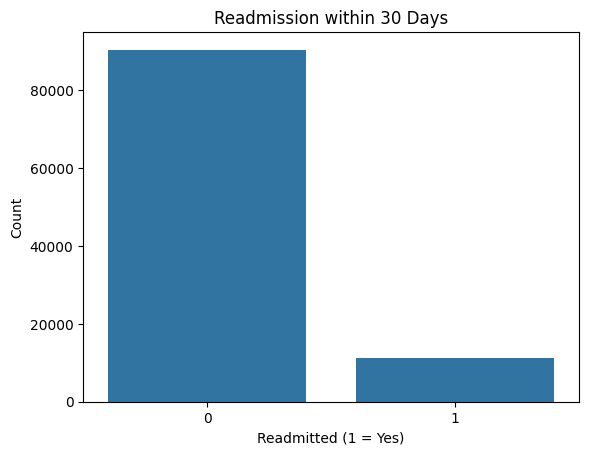

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x='readmit_30', data=df)
plt.title("Readmission within 30 Days")
plt.xlabel("Readmitted (1 = Yes)")
plt.ylabel("Count")
plt.savefig("Visuals/readmission_distribution.png")
plt.show()


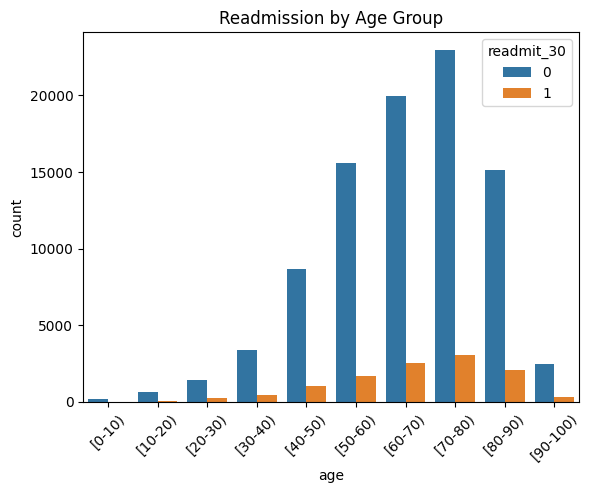

In [25]:
sns.countplot(x='age', hue='readmit_30', data=df, order=sorted(df['age'].unique()))
plt.xticks(rotation=45)
plt.title("Readmission by Age Group")
plt.savefig("Visuals/readmission_by_age.png")
plt.show()


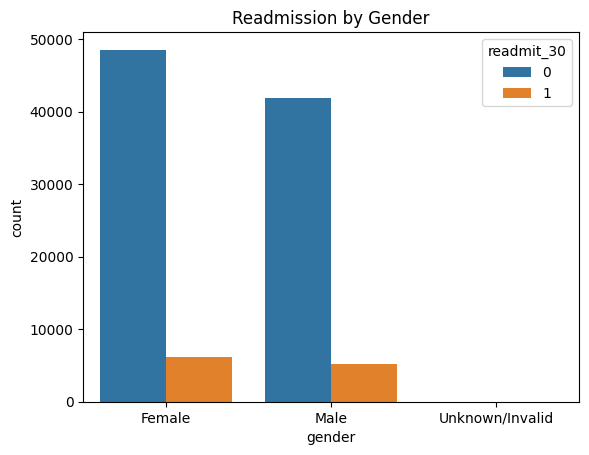

In [26]:
sns.countplot(x='gender', hue='readmit_30', data=df)
plt.title("Readmission by Gender")
plt.savefig("Visuals/readmission_by_gender.png")
plt.show()


In [27]:
# Drop columns with too many missing values or irrelevant for prediction
df.drop(['weight', 'payer_code', 'medical_specialty', 'encounter_id', 'patient_nbr'], axis=1, inplace=True)


In [28]:
df = df[df['gender'] != 'Unknown/Invalid']


In [29]:
# Select categorical columns
categorical_cols = df.select_dtypes(include='object').columns

# Drop the original target
categorical_cols = categorical_cols.drop('readmitted')

# One-hot encode all categorical columns
df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True)


In [30]:
from sklearn.model_selection import train_test_split

X = df_encoded.drop(['readmitted', 'readmit_30'], axis=1)
y = df_encoded['readmit_30']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

# Evaluation
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_pred))


In [33]:
# Example: select only limited categorical columns
selected_cats = [
    'race', 'gender', 'age', 'admission_type_id',
    'discharge_disposition_id', 'admission_source_id',
    'max_glu_serum', 'A1Cresult', 'change', 'diabetesMed'
]

df_filtered = df[selected_cats + ['readmit_30']]  # Add target

# One-hot encode only selected
df_encoded = pd.get_dummies(df_filtered, drop_first=True)


In [34]:
from sklearn.model_selection import train_test_split

X = df_encoded.drop("readmit_30", axis=1)
y = df_encoded["readmit_30"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)


In [35]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)


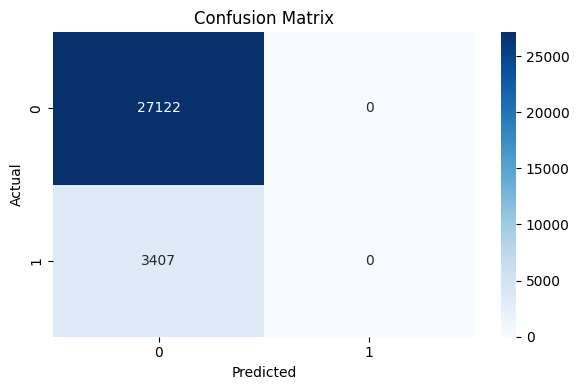

In [36]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.savefig("Visuals/confusion_matrix.png")
plt.show()


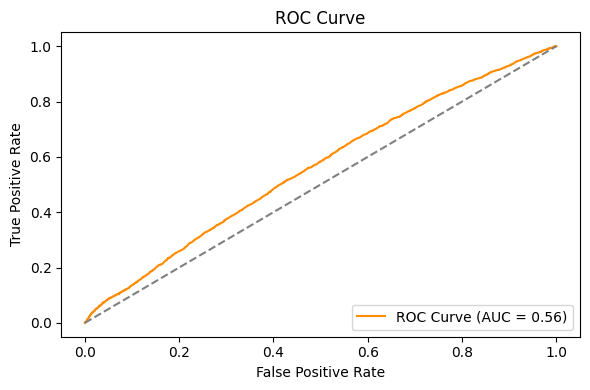

In [37]:
from sklearn.metrics import roc_curve, auc

y_probs = model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color='darkorange', label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.tight_layout()
plt.savefig("Visuals/roc_curve.png")
plt.show()


In [38]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")


Accuracy: 0.8884


In [39]:
from sklearn.metrics import roc_auc_score

y_probs = model.predict_proba(X_test)[:, 1]  # probabilities for class 1
auc_score = roc_auc_score(y_test, y_probs)
print(f"AUC Score: {auc_score:.4f}")


AUC Score: 0.5610


In [40]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score


In [41]:
# Initialize and train
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predict
rf_pred = rf_model.predict(X_test)
rf_probs = rf_model.predict_proba(X_test)[:, 1]


In [42]:
# Accuracy & Report
print("Random Forest Classification Report:\n")
print(classification_report(y_test, rf_pred))

# Confusion Matrix
rf_cm = confusion_matrix(y_test, rf_pred)
print("Confusion Matrix:\n", rf_cm)

# AUC Score
rf_auc = roc_auc_score(y_test, rf_probs)
print(f"Random Forest AUC Score: {rf_auc:.4f}")


Random Forest Classification Report:

              precision    recall  f1-score   support

           0       0.89      0.99      0.94     27122
           1       0.19      0.02      0.04      3407

    accuracy                           0.88     30529
   macro avg       0.54      0.51      0.49     30529
weighted avg       0.81      0.88      0.84     30529

Confusion Matrix:
 [[26814   308]
 [ 3334    73]]
Random Forest AUC Score: 0.5771


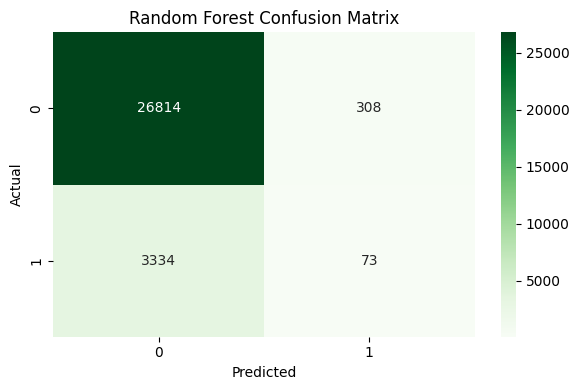

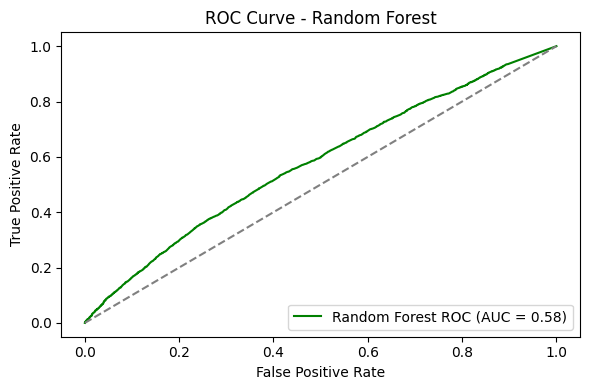

In [43]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc

# Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(rf_cm, annot=True, fmt='d', cmap='Greens')
plt.title("Random Forest Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.savefig("Visuals/rf_confusion_matrix.png")
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, rf_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"Random Forest ROC (AUC = {roc_auc:.2f})", color='green')
plt.plot([0, 1], [0, 1], linestyle='--', color='grey')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Random Forest")
plt.legend(loc="lower right")
plt.tight_layout()
plt.savefig("Visuals/rf_roc_curve.png")
plt.show()


In [44]:
rf_accuracy = accuracy_score(y_test, rf_pred)
rf_auc = roc_auc_score(y_test, rf_probs)

print(f"Random Forest Accuracy: {rf_accuracy:.4f}")
print(f"Random Forest AUC: {rf_auc:.4f}")


Random Forest Accuracy: 0.8807
Random Forest AUC: 0.5771
